# Analyze A/B Test Results 
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)
<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website or a company.As a data analyst, my goal for this project is to help the company decide if they should:  

- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

**a.** Reading the dataset from the `ab_data.csv` file and taking a look at  at the top rows:

In [2]:
df=pd.read_csv("ab_data.csv")

In [3]:
df.tail()

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [4]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [5]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


**b.** Identifying the number of rows in the dataset

In [6]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [7]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [8]:
df.converted.mean()

0.11965919355605512

In [9]:
#total  # users converted
users_converted=df[df['converted']==True].count()
#find the mean
users_converted.mean()

35237.0

In [10]:
#user not converted
users_not_converted=df[df['converted']==False].count()
users_not_converted

user_id         259241
timestamp       259241
group           259241
landing_page    259241
converted       259241
dtype: int64

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [11]:
result_1 = len(df.query('group!="treatment" and landing_page=="new_page"'))
result_2 = len(df.query('group!="control" and landing_page=="old_page"'))
result_1

1928

**f.** Do any of the rows have missing values?

In [12]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 1.2  
**a.** Storing dataframe in df2

In [13]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [14]:
# Double Checking if  all of the incorrect rows were removed from df2 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [15]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [17]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [18]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop_duplicates('user_id');

In [19]:
df2[df2['user_id'].duplicated()]['user_id']

Series([], Name: user_id, dtype: int64)

### 1.4  
**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [20]:
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
df2.query('group =="control"').converted.mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
df2.query('group =="treatment"').converted.mean()

0.11880806551510564

**d.** What is the probability that an individual received the new page?

In [23]:
len(df2[df2['landing_page'] == 'new_page'])/len(df2)

0.5000619442226688

**e.** 
Consider the results above, we cannot reall tell the difference between the groups group control had more conversion compared to experiment group yet there's no concrete evidence to prove wit. 

<a id='ab_test'></a>
## Part II - A/B Test
### 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

### Hypothosis:
<p>
    Null hypothesis: p_new - p_old <= 0  </p>
<p>
Alternative hypothesis: p_new - p_old > 0</p>

### 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [24]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [25]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [26]:
n_new = df2.landing_page.value_counts()[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old = df2.landing_page.value_counts()[1]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [28]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17348

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [29]:
old_page_converted = np.random.binomial(n_old,p_old)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [30]:
diff = (new_page_converted/n_new) - (old_page_converted/n_old)
diff

0.00044537975798038254


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [31]:
old_new_diff = []
for _ in range(10000):
    new_converted = np.random.binomial(n_new,p_new)/n_new
    old_converted = np.random.binomial(n_old,p_old)/n_old
    new_diff = new_converted - old_converted
    old_new_diff.append(new_diff)

**i. Histogram**<br> 

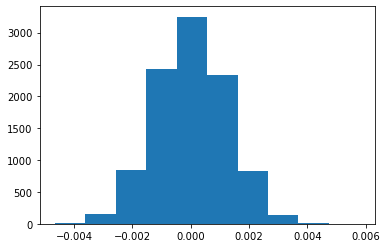

In [32]:
plt.hist(old_new_diff);

In [33]:
import statsmodels.api as sm
convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))


In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [35]:
from scipy.stats import norm
norm.cdf(z_score)
norm.ppf(1-(0.05))

1.6448536269514722

### Observation

<p>We have obsersed less z_score less than 1.6 thus we fail to reject the null hypothesis. </p>

<a id='regression'></a>
### Part III - A regression approach

### 3.1 


#### Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [36]:
df2['intercept']=1
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [37]:
import statsmodels.api as sm
logit = sm.Logit(df2['converted'],df2[['intercept','treatment']])

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:               8.077e-06
Time:                        02:03:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

There difference observed in this project is that in part II, the focus was on one side test, whereas in part III focus was on two side test

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

We could add variables to determine whether they will have influence or not.  However, adding to many features into the regression model can result in over-fitting.

We could also investigate device if they had influence on conversion


**g. Adding countries**<br> 
Adding countries to observe if the results will be impacted by where the user lives.
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [39]:
# Read the countries.csv
countries_df = pd.read_csv("countries.csv")
countries_df = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
countries_df.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [40]:
# Join with the df2 dataframe
countries_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [41]:
# Create the necessary dummy variables
countries_df[['CA', 'US']] = pd.get_dummies(countries_df['country'])[['CA','US']]

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion. 

In [42]:
# Fit your model, and summarize the results
log_mod = sm.Logit(countries_df['converted'],countries_df[['CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                 -0.2214
Time:                        02:03:03   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

Based on the analysis, we conclude neither new page or old page will lead to higher conversion and for this reason we say that we fail to reject the null hypothesis thus we advise the company to keep the old page  or run the test for sometimes.

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])


1